# 🧠 fMRI Decoding with the Haxby Dataset

This project performs multivariate pattern analysis (MVPA) on the Haxby 2001 fMRI dataset using Python and nilearn. The goal is to classify visual stimuli (faces vs. houses) based on brain activation patterns, and to explore spatially localized decoding using Searchlight analysis and the structure of neural representation using Representational Similarity Analysis (RSA).

* fMRI data masking and preprocessing
* Supervised classification (Support Vector Machines)
* Cross-validation and performance evaluation
* Spatial searchlight decoding
* Representational similarity analysis (RSA)



In [25]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image, masking, plotting, input_data
from nilearn.decoding import SearchLight
from nilearn.image import index_img
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.svm import SVC
from scipy.spatial.distance import pdist, squareform

### Load Data, Extract Stimuli Labels, and Preprocess fMRI Data
This block downloads the Haxby dataset and loads the relevant files. It applies the brain mask and standardizes the voxel time series. It then filters the data to keep only trials labeled 'face' or 'house' for binary classification.



In [26]:
# Fetch dataset
dataset = datasets.fetch_haxby(data_dir='haxby_data')
func_filename = dataset.func[0]
labels_filename = dataset.session_target[0]
mask_filename = dataset.mask_vt[0]

# Load behavioral labels
labels = np.genfromtxt(labels_filename, names=True, dtype=None, encoding='utf-8')
stimuli = labels['labels']
runs = labels['chunks']

# Masking and Preprocessing
masker = input_data.NiftiMasker(mask_img=mask_filename, standardize=True)
fmri_masked = masker.fit_transform(func_filename)

# Select only 'face' and 'house' conditions
condition_mask = np.logical_or(stimuli == 'face', stimuli == 'house')
X = fmri_masked[condition_mask]
y = stimuli[condition_mask].astype(str)
runs_selected = runs[condition_mask]

[fetch_haxby] Dataset found in haxby_data/haxby2001


### Train and Evaluate Classifier

This section trains a linear Support Vector Machine (SVM) classifier and evaluates it using 5-fold stratified cross-validation. It reports accuracy and displays a confusion matrix to visualize classification performance across the two classes.

Cross-validation accuracy: [1.         0.95348837 1.         1.         0.97674419]
Mean accuracy: 0.99


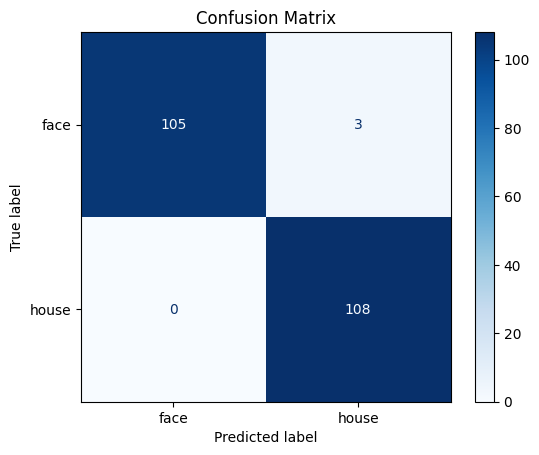

In [27]:
# Train SVM Classifier with Cross-Validation
svc = SVC(kernel='linear')
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(svc, X, y, cv=skf)
print(f"Cross-validation accuracy: {scores}")
print(f"Mean accuracy: {np.mean(scores):.2f}")

# Confusion Matrix
y_pred = cross_val_predict(svc, X, y, cv=skf)
cm = confusion_matrix(y, y_pred, labels=['face', 'house'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['face', 'house'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Spatial Searchlight Decoding

This block performs searchlight analysis, which applies a classifier to spherical neighborhoods (radius = 5.6 mm) throughout the brain to generate a spatial map of classification accuracy. This reveals which regions contain decodable information about the stimuli. The results are visualized as a statistical map.

/var/folders/nm/pm5vb_q97p34xl4t1d194r500000gn/T/ipykernel_74743/393403068.py:16: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  searchlight.fit(fmri_img_sl, y_sl)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[_group_iter_search_light] Job #1, processed 0/47 steps (0.00%, 1879.6 seconds remaining)

[_group_iter_search_light] Job #2, processed 0/47 steps (0.00%, 2275.8 seconds remaining)

[_group_iter_search_light] Job #3, processed 0/47 steps (0.00%, 2456.7 seconds remaining)

[_group_iter_search_light] Job #6, processed 0/46 steps (0.00%, 2813.1 seconds remaining)

[_group_iter_search_light] Job #4, processed 0/47 steps (0.00%, 2704.9 seconds remaining)

[_group_iter_search_light] Job #7, processed 0/46 steps (0.00%, 3148.9 seconds remaining)

[_group_iter_search_light] Job #8, processed 0/46 steps (0.00%, 3714.6 seconds remaining)

[_group_iter_search_light] Job #5, processed 0/46 steps (0.00%, 3834.2 seconds remaining)

[_group_iter_search_light] Job #10, processed 0/46 steps (0.00%, 5571.0 seconds remaining)

[_group_iter_search_light] Job #4, processed 10/47 steps (21.28%, 6.5 seconds remaining)

[_group_iter_search_light] Job #9, processed 0/46 steps (0.00%, 24588.6 seconds remaining)

[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   20.7s remaining:  1.4min


[_group_iter_search_light] Job #1, processed 40/47 steps (85.11%, 3.2 seconds remaining)

[_group_iter_search_light] Job #10, processed 20/46 steps (43.48%, 25.4 seconds remaining)

[_group_iter_search_light] Job #6, processed 30/46 steps (65.22%, 10.8 seconds remaining)

[_group_iter_search_light] Job #2, processed 40/47 steps (85.11%, 3.7 seconds remaining)

[_group_iter_search_light] Job #9, processed 20/46 steps (43.48%, 32.9 seconds remaining)

[_group_iter_search_light] Job #8, processed 20/46 steps (43.48%, 34.0 seconds remaining)

[_group_iter_search_light] Job #10, processed 30/46 steps (65.22%, 14.2 seconds remaining)

[_group_iter_search_light] Job #7, processed 20/46 steps (43.48%, 35.1 seconds remaining)

[_group_iter_search_light] Job #3, processed 30/47 steps (63.83%, 16.5 seconds remaining)

[_group_iter_search_light] Job #6, processed 40/46 steps (86.96%, 4.6 seconds remaining)

[_group_iter_search_light] Job #7, processed 30/46 steps (65.22%, 17.2 seconds remaining)



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   53.4s finished


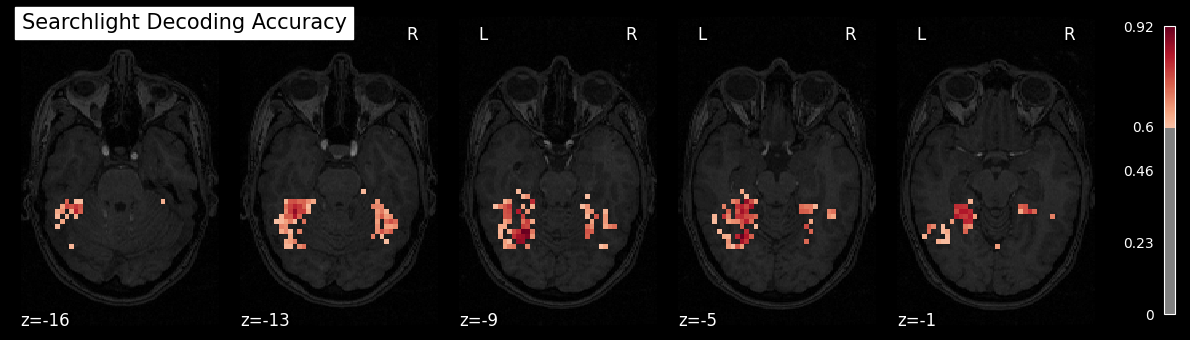

In [28]:
# Searchlight Decoding
fmri_img = image.load_img(func_filename)
conditions = np.logical_or(stimuli == 'face', stimuli == 'house')
y_sl = stimuli[conditions].astype(str)
fmri_img_sl = index_img(fmri_img, np.where(conditions)[0])

searchlight = SearchLight(
    mask_img=mask_filename,
    process_mask_img=mask_filename,
    radius=5.6,
    estimator=SVC(kernel="linear"),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1)

searchlight.fit(fmri_img_sl, y_sl)

searchlight_img = image.new_img_like(mask_filename, searchlight.scores_)

plotting.plot_stat_map(
    searchlight_img,
    bg_img=dataset.anat[0],
    title="Searchlight Decoding Accuracy",
    threshold=0.6,
    display_mode='z',
    cut_coords=5)
plt.show()

### Representational Similarity Analysis (RSA)

The neural dissimilarity matrix shows how different the brain patterns are for each time point. The category matrix shows the binary difference between 'face' and 'house' labels. RSA helps reveal whether brain patterns align more closely within the same stimulus category, indicating category-specific neural representations.

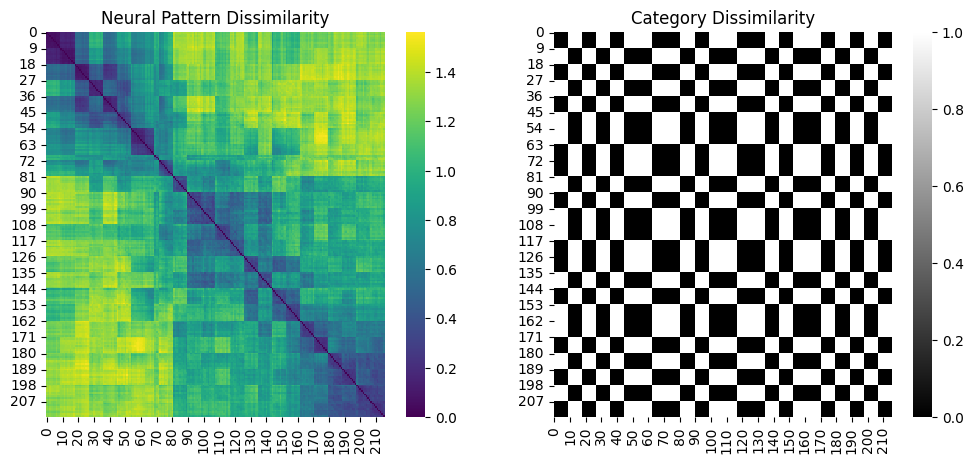

In [29]:
# Representational Similarity Analysis (RSA)
dist_matrix = squareform(pdist(X, metric='correlation'))

label_bin = np.array([0 if l == 'face' else 1 for l in y])
category_matrix = (label_bin[:, None] != label_bin[None, :]).astype(float)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(dist_matrix, ax=axes[0], cmap='viridis')
axes[0].set_title("Neural Pattern Dissimilarity")
sns.heatmap(category_matrix, ax=axes[1], cmap='gray')
axes[1].set_title("Category Dissimilarity")
plt.show()

The decoding pipeline applied to the Haxby 2001 dataset yielded highly accurate classification of visual categories (face vs. house) based on fMRI signals. The cross-validation scores across 5 folds were exceptionally high [1.00, 0.95, 1.00, 1.00, 0.98] with a mean accuracy of 0.99, indicating robust and generalizable performance of the linear SVM classifier.

The confusion matrix further confirms this performance with the model correctly identifying 105 out of 108 face trials and all 108 house trials. Only 3 face samples were misclassified as house, with no misclassifications for house trials. This near-perfect result reflects highly discriminable neural patterns between face and house stimuli in the ventral temporal cortex.

The searchlight decoding analysis reveals where this information is spatially localized in the brain. Clusters of high classification accuracy (above 0.6) are prominently observed bilaterally in the fusiform gyrus and parahippocampal cortex, which are known to selectively respond to faces and scenes, respectively. The left fusiform region, in particular, shows peak accuracy approaching 0.92, suggesting a concentrated region of category-specific neural coding. These results mirror known functional specializations (FFA and PPA) and validate the effectiveness of localized MVPA approaches.

In the Representational Similarity Analysis (RSA), the neural dissimilarity matrix shows distinct block patterns, where within-category comparisons (face-face or house-house) show lower dissimilarity (cooler colors), and between-category comparisons show higher dissimilarity. The category dissimilarity matrix encodes binary differences between face and house labels, forming a checkerboard pattern. The alignment of structure between the neural and category matrices indicates that the brain's activation patterns reflect category membership. This supports the idea that neural representations in the ventral temporal cortex are categorically organized across trials.